In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.classical import expr   # allows classical logic on mid circuit measurement

In [2]:
def get_ghz_circ_dynamic_1(num_qubit):   
    if num_qubit%2==1:                                                  # For odd number of qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int(num_qubit/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)

    else:                                                               # For even number of Qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int((num_qubit-1)/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

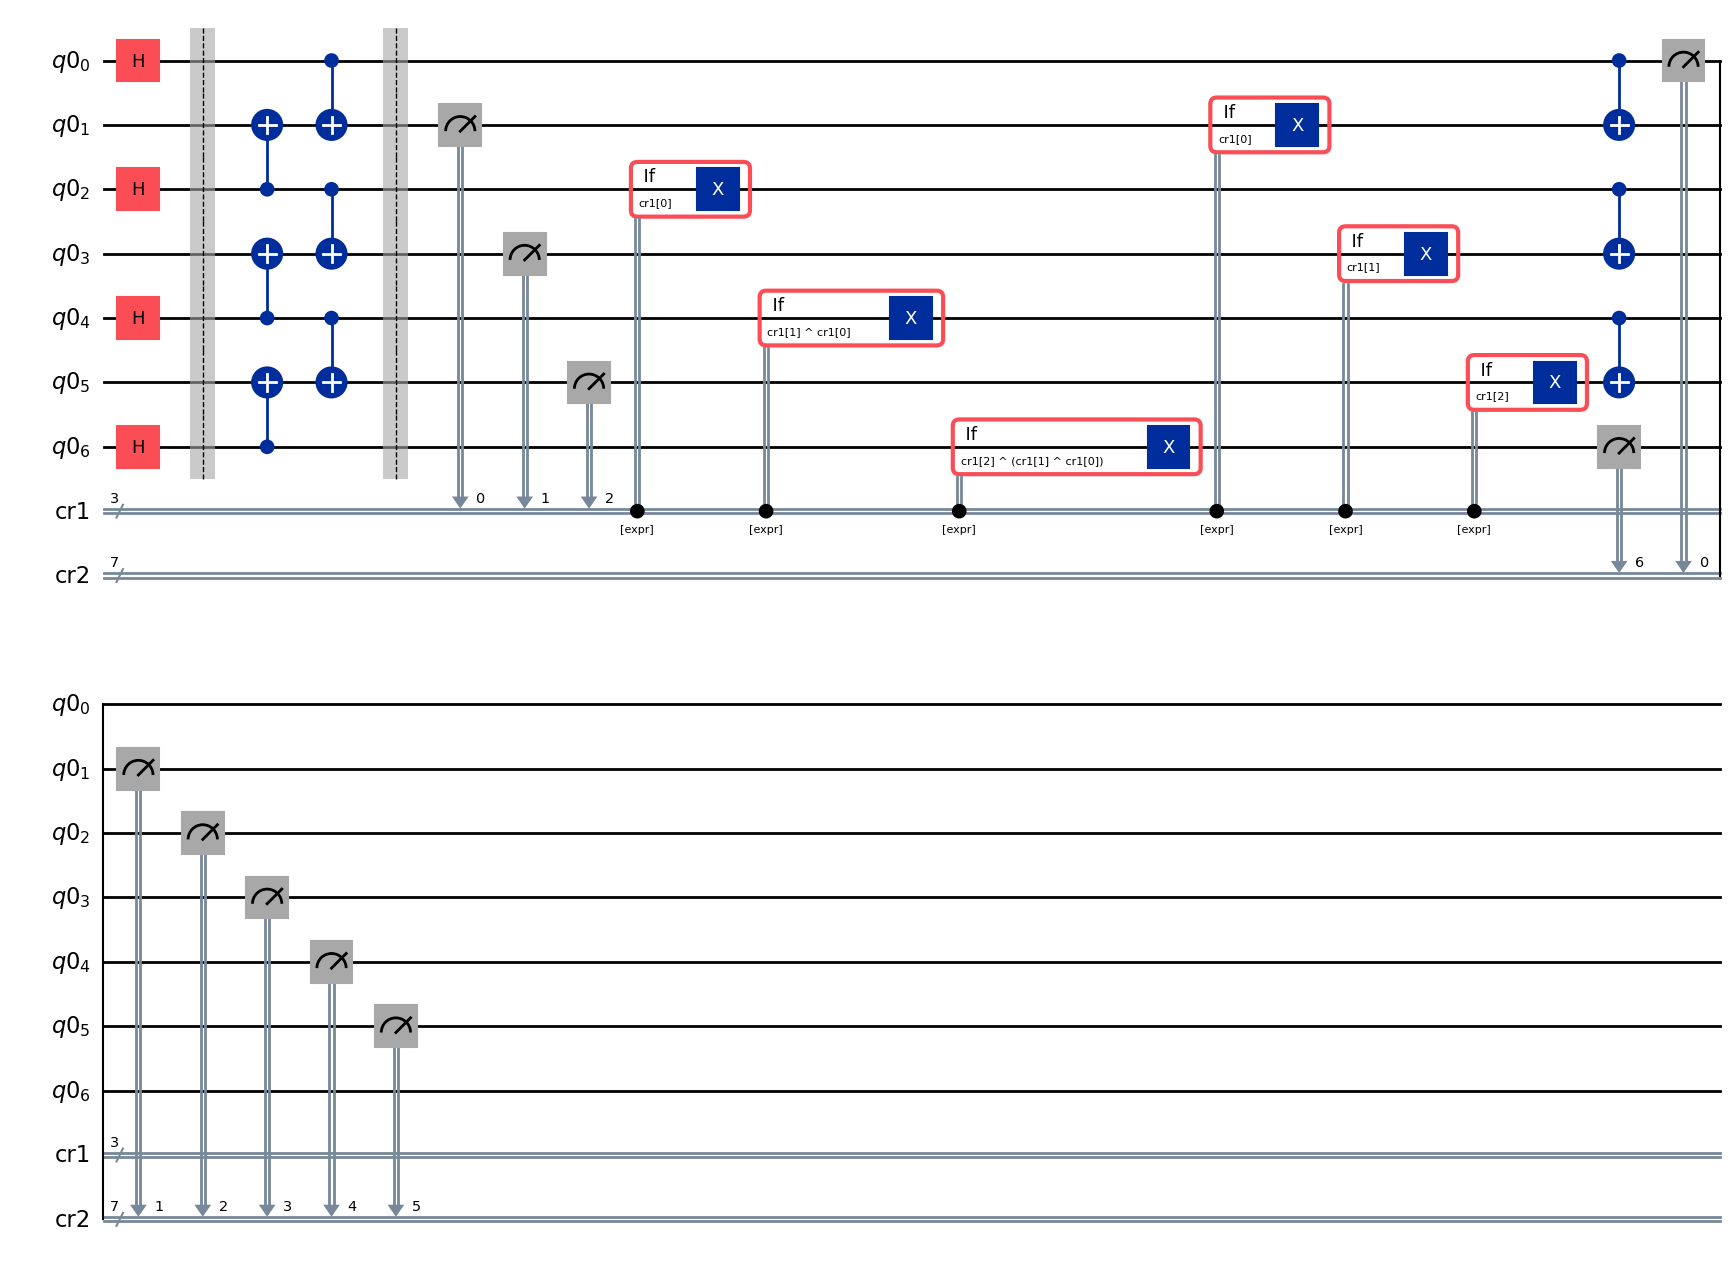

In [3]:
qc = get_ghz_circ_dynamic_1(num_qubit=7)
qc.draw("mpl")

In [4]:
#Creating list of circuits i.e. some copies of each of them

min_qubit=5
max_num_qubit=5
copies=1

#qc_list_dynamic_1=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_dynamic_1(num_qubit))
print(num_qubit_list)

[5]


In [5]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, basis_gates=['snapshot', 'store', 'measure', 'barrier', 'h', 'cx'], translation_method='translator')
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [6]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [7]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=2>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>)))], metadata={})


1

In [9]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):    
        data_dynamic_1 = result_ideal[(i*copies)+j].data

        print(data_dynamic_1)
        
        counts_dynamic_1=data_dynamic_1.cr2.get_counts()
        
        counts_list_ideal.append(counts_dynamic_1)

DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=2>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))


In [10]:
#Transpilation in real hardware

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance="ibm-q/open/main")
service.backends()

[<IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_brisbane')>]

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

In [13]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list,shots=1024)
print(job.job_id())

csyn3tf0t33000811b8g


In [14]:
#Post-processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'csyn3tf0t33000811b8g' #Brisbane

service = QiskitRuntimeService()
job = service.job(job_id)
result_real = job.result()

In [15]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=2>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'circuit_metadata': {}})], metadata={'version': 2})


1

In [18]:
#Finding the metrics of the job
result_metric_real=job.metrics()
print(result_metric_real)

{'timestamps': {'created': '2024-06-27T11:50:01.926731Z', 'finished': '2024-06-27T14:31:08.392Z', 'running': '2024-06-27T14:30:52.288Z'}, 'bss': {'seconds': 2}, 'usage': {'quantum_seconds': 2, 'seconds': 2}, 'executions': 0, 'num_circuits': 0, 'qiskit_version': 'qiskit_ibm_runtime-0.23.0,qiskit-1.1.0*,qiskit_aer-0.13.3*,qiskit_experiments-0.7.0', 'estimated_start_time': '2024-06-27T14:19:08.225Z', 'estimated_completion_time': '2024-06-27T14:19:09.846Z', 'caller': 'qiskit_ibm_runtime~sampler.py'}


In [17]:
#Finding the runtime usage separately
result_usage_real=job.metrics()['usage']

print(result_usage_real)

print("Runtime Usage Information:")
for resource, usage in result_usage_real.items():
    print(f"{resource}: {usage}")

{'quantum_seconds': 2, 'seconds': 2}
Runtime Usage Information:
quantum_seconds: 2
seconds: 2


In [20]:
# For getting list of real counts of IBM brisbane (argument required for Fidelity)
counts_list_real=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_dynamic_1 = result_real[(i*copies)+j].data

        print(data_dynamic_1)
        
        counts_dynamic_1=data_dynamic_1.cr2.get_counts()
        
        counts_list_real.append(counts_dynamic_1)

DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=2>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))


In [21]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_brisbane
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_dynamic_1_brisbane=[]

#Fidelity_std_dynamic_1_brisbane=[]

Fidelity_copies_dynamic_1_brisbane=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(i*copies)+j], counts_list_real[(i*copies)+j])
        
        Fidelity_copies_dynamic_1_brisbane.append(Fidelity_dynamic_1)
    

    Fidelity_mean_dynamic_1_brisbane.append(statistics.mean(Fidelity_copies_dynamic_1_brisbane))
    
    #Fidelity_std_dynamic_1_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_1_brisbane))
    
    Fidelity_copies_dynamic_1_brisbane.clear()

[0.3432317454361471]


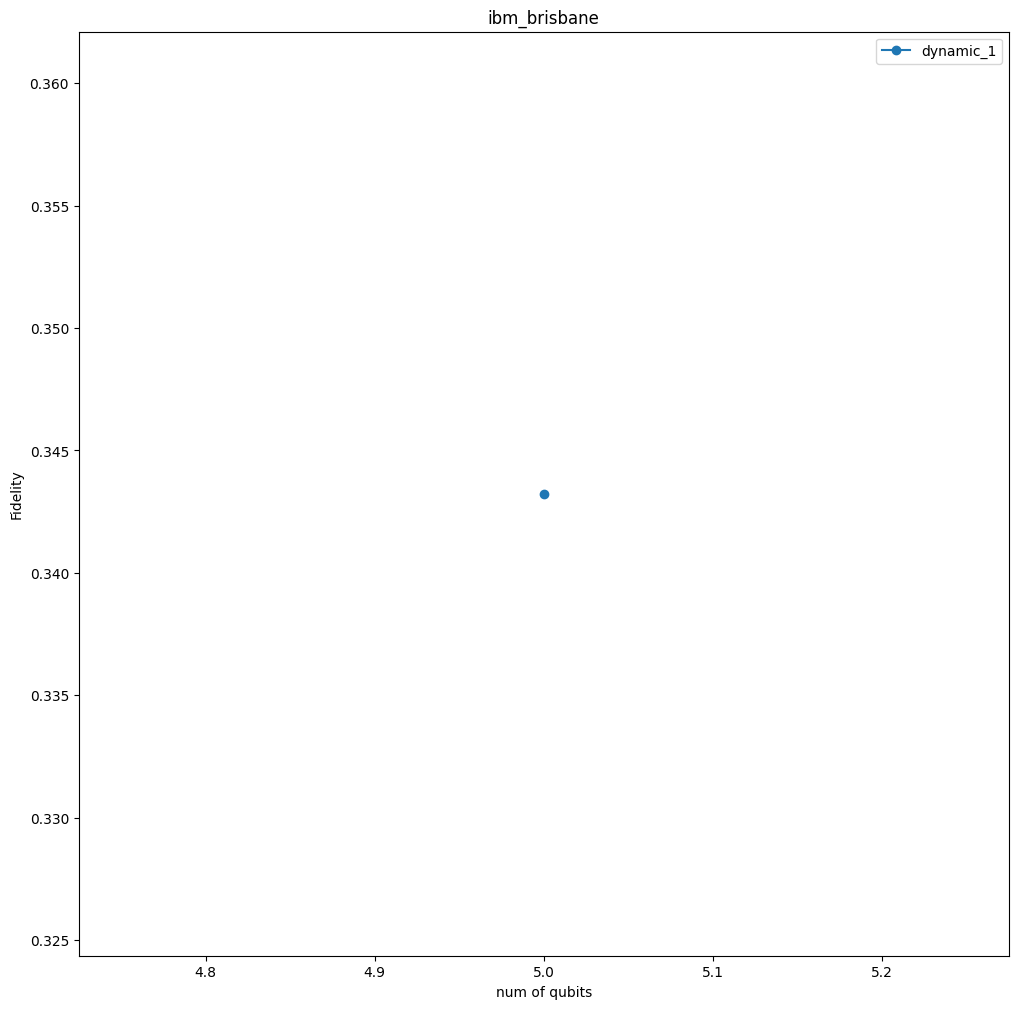

In [23]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_dynamic_1 = Fidelity_mean_dynamic_1_brisbane
print(y1_dynamic_1)
#y_error_dynamic_1 =Fidelity_std_dynamic_1_brisbane
ax1.plot(x1, y1_dynamic_1, 'o-',label='dynamic_1')
#ax1.errorbar(x1, y1_dynamic_1,
#			yerr = y_error_dynamic_1, label='dynamic_1',
#			fmt ='o')


plt.legend()
plt.show()